In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Two 2D Gaussian Classes (1,000 samples each)

This notebook generates two classes of 2D points from multivariate normal distributions:

- **Class 0**: mean = [2, 2], covariance = [[0.5, 0], [0, 0.5]]
- **Class 1**: mean = [5, 5], covariance = [[0.5, 0], [0, 0.5]]

It previews the data, shows a quick scatter plot, and saves to CSV (and Parquet if available).


In [53]:
# Reproducibility
seed = 120901
rng = np.random.default_rng(seed)

# Class parameters
mean0 = np.array([2.0, 2.0])
mean1 = np.array([5.0, 5.0])
cov = np.array([[0.5, 0.0],
                [0.0, 0.5]])

n_per_class = 1000

# Output names
out_prefix = "two_class_data"
csv_path = f"{out_prefix}.csv"
parquet_path = f"{out_prefix}.parquet"
png_path = f"{out_prefix}.png"


In [54]:
# Generate samples
X0 = rng.multivariate_normal(mean0, cov, size=n_per_class)
X1 = rng.multivariate_normal(mean1, cov, size=n_per_class)

# To DataFrames
df0 = pd.DataFrame(X0, columns=["x", "y"])
df0["class"] = 0

df1 = pd.DataFrame(X1, columns=["x", "y"])
df1["class"] = 1

# Combined dataset
df = pd.concat([df0, df1], ignore_index=True)
df.head()

X = df[["x", "y"]].to_numpy(dtype=float)
y = df["class"].to_numpy(dtype=int)

X_mean = X.mean(axis=0)
X_std  = X.std(axis=0) + 1e-12
X_stdzd = (X - X_mean) / X_std



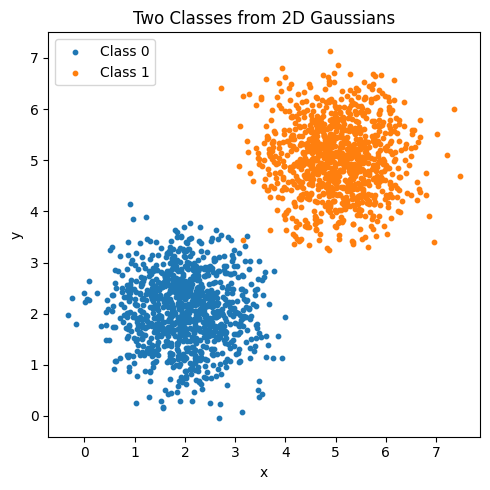

In [55]:
plt.figure(figsize=(5, 5))
mask0 = df["class"] == 0
mask1 = df["class"] == 1

plt.scatter(df.loc[mask0, "x"], df.loc[mask0, "y"], s=10, label="Class 0")
plt.scatter(df.loc[mask1, "x"], df.loc[mask1, "y"], s=10, label="Class 1")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Two Classes from 2D Gaussians")
plt.legend()
plt.tight_layout()
plt.show()


In [56]:
# CSV always
df.to_csv(csv_path, index=False)
print(f"Saved CSV -> {csv_path}")

# Parquet if an engine is installed
try:
    df.to_parquet(parquet_path, index=False)  # requires 'pyarrow' or 'fastparquet'
    print(f"Saved Parquet -> {parquet_path}")
except Exception as e:
    print("Parquet not saved (install 'pyarrow' or 'fastparquet' to enable).")
    print("Reason:", e)


Saved CSV -> two_class_data.csv
Saved Parquet -> two_class_data.parquet


In [57]:
# Convert 0 -> -1, 1 -> +1 for perceptron update rule
y_bin = np.where(y == 1, 1, -1)

# Initialize weights (w) as 2D vector and bias (b) as scalar
w = np.zeros(2, dtype=float)
b = 0.0
n = 0.01

# Alternatively, small random initialization:
# w = rng.normal(0, 0.01, size=2)
# b = 0.0

w, b, n


(array([0., 0.]), 0.0, 0.01)

In [58]:
def perceptron_predict_bin(X, w, b):
    a = X @ w + b
    return np.where(a >= 0, 1, -1)  # returns ±1

def accuracy_bin(y_true_bin, y_pred_bin):
    return float((y_true_bin == y_pred_bin).mean())


In [59]:
def perceptron_train_until_converged(
    X, y_bin, w, b, n=0.01, max_epochs=100, shuffle=True, seed=120901
):
    N = X.shape[0]
    rng = np.random.default_rng(seed)

    acc_history = []
    mistakes_history = []
    epochs_run = 0
    converged = False

    for epoch in range(1, max_epochs + 1):
        if shuffle:
            idx = np.arange(N)
            rng.shuffle(idx)
            Xe, ye = X[idx], y_bin[idx]
        else:
            Xe, ye = X, y_bin

        mistakes = 0

        for xi, yi in zip(Xe, ye):
            a = float(np.dot(w, xi) + b)
            if yi * a <= 0:
                w = w + n * yi * xi
                b = b + n * yi
                mistakes += 1

        # After completing this epoch, compute accuracy on the full dataset
        y_hat = perceptron_predict_bin(X, w, b)
        acc = accuracy_bin(y_bin, y_hat)
        acc_history.append(acc)
        mistakes_history.append(mistakes)

        epochs_run = epoch
        if mistakes == 0:
            converged = True
            break

    return {
        "w": w,
        "b": b,
        "acc_history": acc_history,
        "mistakes_history": mistakes_history,
        "epochs_run": epochs_run,
        "converged": converged,
    }

result = perceptron_train_until_converged(X, y_bin, w, b, n=n, max_epochs=100, shuffle=True, seed=seed)
result["converged"], result["epochs_run"], result["acc_history"][:5], result["mistakes_history"][:5]


(False, 100, [0.9995, 0.9995, 0.9995, 0.9995, 0.999], [54, 9, 20, 17, 26])

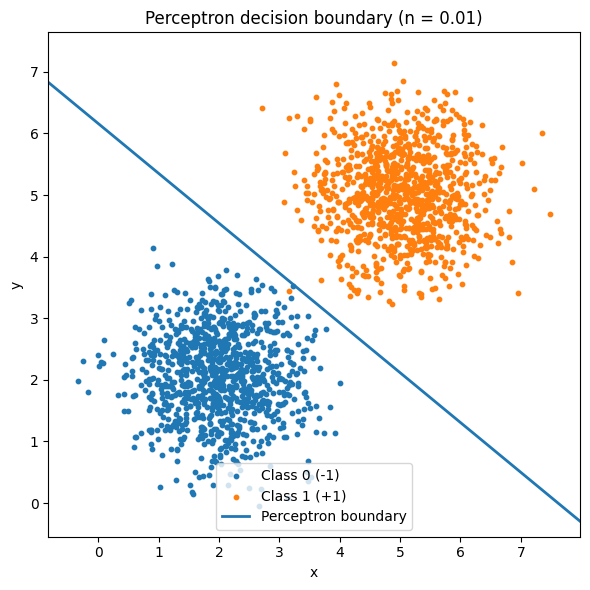

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Use the trained parameters
w_tr, b_tr = result["w"], result["b"]

# Scatter the data
mask0 = (y_bin == -1)
mask1 = (y_bin == 1)

plt.figure(figsize=(6, 6))
plt.scatter(X[mask0, 0], X[mask0, 1], s=10, label="Class 0 (-1)")
plt.scatter(X[mask1, 0], X[mask1, 1], s=10, label="Class 1 (+1)")

# Plot decision boundary: w0*x + w1*y + b = 0
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
eps = 1e-12

if abs(w_tr[1]) > eps:
    xs = np.linspace(x_min, x_max, 400)
    ys = -(w_tr[0] * xs + b_tr) / w_tr[1]
    plt.plot(xs, ys, linewidth=2, label="Perceptron boundary")
elif abs(w_tr[0]) > eps:
    # Vertical boundary
    x0 = -b_tr / w_tr[0]
    plt.axvline(x0, linewidth=2, label="Perceptron boundary")
else:
    print("Weights near zero; boundary not defined yet.")

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Perceptron decision boundary (n = 0.01)")
plt.legend()
plt.tight_layout()
plt.show()


In [63]:
y_pred_bin = perceptron_predict(X, w_tr, b_tr)
acc = (y_pred_bin == y_bin).mean()
print(f"Training accuracy: {acc:.4f} | epochs={result['epochs_run']} | converged={result['converged']}")


Training accuracy: 0.9965 | epochs=100 | converged=False


In [64]:
if result["converged"]:
    print(f"Converged in {result['epochs_run']} epoch(s).")
    print(f"Final training accuracy: {result['acc_history'][-1]:.4f}")
else:
    print("Did not converge within 100 epochs.")
    print(f"Training accuracy at 100 epochs: {result['acc_history'][-1]:.4f}")

print("Weights:", result["w"])
print("Bias:", result["b"])


Did not converge within 100 epochs.
Training accuracy at 100 epochs: 0.9995
Weights: [0.12208697 0.15098059]
Bias: -0.9300000000000006


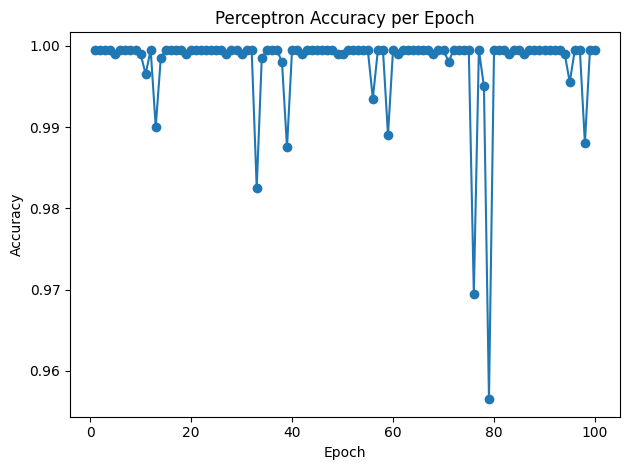

In [37]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, result["epochs_run"] + 1), result["acc_history"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Perceptron Accuracy per Epoch")
plt.tight_layout()
plt.show()


## Excercise 2

In [38]:
# Reproducibility
seed = 120901
rng = np.random.default_rng(seed)

# Class parameters
mean0 = np.array([3.0, 3.0])
mean1 = np.array([4.0, 4.0])
cov = np.array([[1.5, 0.0],
                [0.0, 0.5]])

n_per_class = 1000

# Output names
out_prefix = "two_class_data_2"
csv_path = f"{out_prefix}.csv"
parquet_path = f"{out_prefix}.parquet"
png_path = f"{out_prefix}.png"


In [39]:
# Generate samples
X0 = rng.multivariate_normal(mean0, cov, size=n_per_class)
X1 = rng.multivariate_normal(mean1, cov, size=n_per_class)

# To DataFrames
df0 = pd.DataFrame(X0, columns=["x", "y"])
df0["class"] = 0

df1 = pd.DataFrame(X1, columns=["x", "y"])
df1["class"] = 1

# Combined dataset
df = pd.concat([df0, df1], ignore_index=True)
df.head()

X = df[["x", "y"]].to_numpy(dtype=float)
y = df["class"].to_numpy(dtype=int)


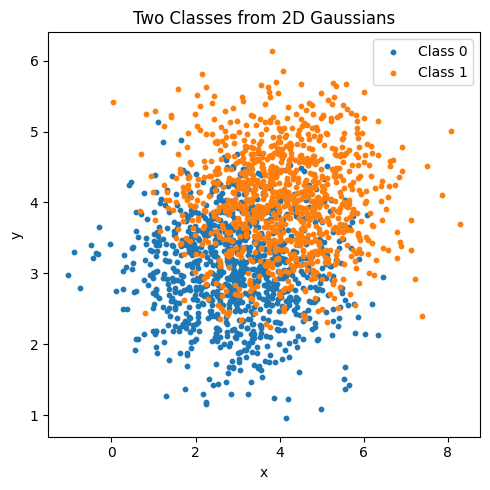

In [40]:
plt.figure(figsize=(5, 5))
mask0 = df["class"] == 0
mask1 = df["class"] == 1

plt.scatter(df.loc[mask0, "x"], df.loc[mask0, "y"], s=10, label="Class 0")
plt.scatter(df.loc[mask1, "x"], df.loc[mask1, "y"], s=10, label="Class 1")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Two Classes from 2D Gaussians")
plt.legend()
plt.tight_layout()
plt.show()


In [41]:
# CSV always
df.to_csv(csv_path, index=False)
print(f"Saved CSV -> {csv_path}")

# Parquet if an engine is installed
try:
    df.to_parquet(parquet_path, index=False)  # requires 'pyarrow' or 'fastparquet'
    print(f"Saved Parquet -> {parquet_path}")
except Exception as e:
    print("Parquet not saved (install 'pyarrow' or 'fastparquet' to enable).")
    print("Reason:", e)


Saved CSV -> two_class_data_2.csv
Saved Parquet -> two_class_data_2.parquet


In [ ]:
# Convert 0 -> -1, 1 -> +1 for perceptron update rule
y_bin = np.where(y == 1, 1, -1)

# Initialize weights (w) as 2D vector and bias (b) as scalar
w = np.zeros(2, dtype=float)
b = 0.0
n = 0.01

# Alternatively, small random initialization:
# w = rng.normal(0, 0.01, size=2)
# b = 0.0

w, b, n


(array([0., 0.]), 0.0, 0.01)

In [43]:
def perceptron_predict_bin(X, w, b):
    a = X @ w + b
    return np.where(a >= 0, 1, -1)  # returns ±1

def accuracy_bin(y_true_bin, y_pred_bin):
    return float((y_true_bin == y_pred_bin).mean())


In [44]:
def perceptron_train_until_converged(
    X, y_bin, w, b, n=0.01, max_epochs=100, shuffle=True, seed=120901
):
    """
    Train perceptron with update:
      If y*(w·x + b) <= 0:
          w <- w + n*y*x
          b <- b + n*y

    Stops when a full pass makes no updates (converged) or max_epochs is reached.
    Tracks accuracy after each epoch (post-updates of that epoch).
    """
    N = X.shape[0]
    rng = np.random.default_rng(seed)

    acc_history = []
    mistakes_history = []
    epochs_run = 0
    converged = False

    for epoch in range(1, max_epochs + 1):
        if shuffle:
            idx = np.arange(N)
            rng.shuffle(idx)
            Xe, ye = X[idx], y_bin[idx]
        else:
            Xe, ye = X, y_bin

        mistakes = 0

        for xi, yi in zip(Xe, ye):
            a = float(np.dot(w, xi) + b)
            if yi * a <= 0:
                w = w + n * yi * xi
                b = b + n * yi
                mistakes += 1

        # After completing this epoch, compute accuracy on the full dataset
        y_hat = perceptron_predict_bin(X, w, b)
        acc = accuracy_bin(y_bin, y_hat)
        acc_history.append(acc)
        mistakes_history.append(mistakes)

        epochs_run = epoch
        if mistakes == 0:
            converged = True
            break

    return {
        "w": w,
        "b": b,
        "acc_history": acc_history,
        "mistakes_history": mistakes_history,
        "epochs_run": epochs_run,
        "converged": converged,
    }

result = perceptron_train_until_converged(X, y_bin, w, b, n=n, max_epochs=100, shuffle=True, seed=seed)
result["converged"], result["epochs_run"], result["acc_history"][:5], result["mistakes_history"][:5]


(False, 100, [0.7915, 0.501, 0.787, 0.6975, 0.7895], [730, 651, 608, 574, 587])

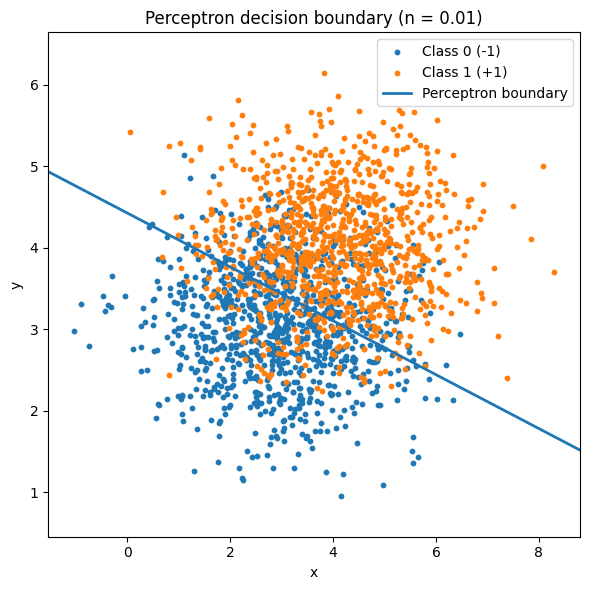

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Use the trained parameters
w_tr, b_tr = result["w"], result["b"]

# Scatter the data
mask0 = (y_bin == -1)
mask1 = (y_bin == 1)

plt.figure(figsize=(6, 6))
plt.scatter(X[mask0, 0], X[mask0, 1], s=10, label="Class 0 (-1)")
plt.scatter(X[mask1, 0], X[mask1, 1], s=10, label="Class 1 (+1)")

# Plot decision boundary: w0*x + w1*y + b = 0
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
eps = 1e-12

if abs(w_tr[1]) > eps:
    xs = np.linspace(x_min, x_max, 400)
    ys = -(w_tr[0] * xs + b_tr) / w_tr[1]
    plt.plot(xs, ys, linewidth=2, label="Perceptron boundary")
elif abs(w_tr[0]) > eps:
    # Vertical boundary
    x0 = -b_tr / w_tr[0]
    plt.axvline(x0, linewidth=2, label="Perceptron boundary")
else:
    print("Weights near zero; boundary not defined yet.")

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Perceptron decision boundary (n = 0.01)")
plt.legend()
plt.tight_layout()
plt.show()


In [46]:
y_pred_bin = perceptron_predict(X, w_tr, b_tr)
acc = (y_pred_bin == y_bin).mean()
print(f"Training accuracy: {acc:.4f} | epochs={result['epochs_run']} | converged={result['converged']}")


Training accuracy: 0.7735 | epochs=100 | converged=False


In [48]:
if result["converged"]:
    print(f"Converged in {result['epochs_run']} epoch(s).")
    print(f"Final training accuracy: {result['acc_history'][-1]:.4f}")
else:
    print("Did not converge within 100 epochs.")
    print(f"Training accuracy at 100 epochs: {result['acc_history'][-1]:.4f}")

print("Weights:", result["w"])
print("Bias:", result["b"])


Did not converge within 100 epochs.
Training accuracy at 100 epochs: 0.7735
Weights: [0.06873479 0.20793337]
Bias: -0.9200000000000006


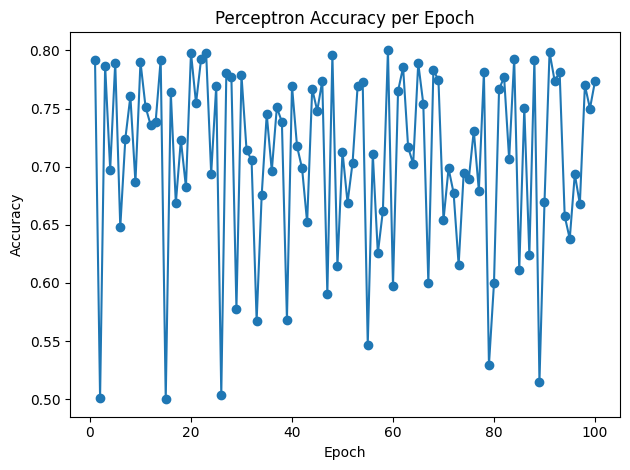

In [49]:
plt.figure()
plt.plot(range(1, result["epochs_run"] + 1), result["acc_history"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Perceptron Accuracy per Epoch")
plt.tight_layout()
plt.show()